# AI Weather Prediction Project Notebook

#### Order
1. Decision Tree Regressor
2. XGBoost Classification: Precipitation Percentage
3. XGBoost Classification: Precipitation Category
4. TensorFlow Neuro Network

#### Load Libraries to be used by all models. 

In [873]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from joblib import dump, load

plt.rcParams['figure.figsize']=(6,4)

In [874]:
!pip install openpyxl


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [875]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Decision Tree Regressor

In [876]:
weather_data = pd.read_csv('weather_data_excel.csv')
print(weather_data.columns)


Index(['Location', 'Date_Time', 'Temperature_C', 'Humidity_pct',
       'Precipitation_mm', 'Wind_Speed_kmh', 'Temperature_F', 'Date',
       'Military_Time', 'Rain_Category', 'Rain_Cat_Num', 'Precipitation_in'],
      dtype='object')


In [877]:
y = weather_data['Precipitation_mm']
X = weather_data.drop(columns=['Precipitation_mm', 'Rain_Category', 'Location', 'Date', 'Military_Time',  'Precipitation_in', 'Temperature_C', 'Rain_Cat_Num', 'Date_Time'])

In [878]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F'], dtype='object')

In [879]:
y.describe()

count    1000000.000000
mean           5.109639
std            2.947997
min            0.000009
25%            2.580694
50%            5.109917
75%            7.613750
max           14.971583
Name: Precipitation_mm, dtype: float64

In [880]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [881]:
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (800000, 3)
y_train.shape =  (800000,)
X_test.shape =  (200000, 3)
y_test.shape =  (200000,)


In [882]:
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [883]:
y_train_pred = dt.predict(X_train)
print(r2_score(y_train, y_train_pred))
y_test_pred = dt.predict(X_test)
print(r2_score(y_test, y_test_pred))

0.004898586865713206
0.000531327867751008


In [884]:
y_train_pred

array([5.12046901, 4.98621948, 5.03610625, ..., 5.1184418 , 5.0950171 ,
       5.1471174 ])

In [885]:
y_test_pred

array([5.11379906, 5.03610625, 5.09760783, ..., 5.03610625, 5.1471174 ,
       5.1184418 ])

In [886]:
training_r2 = []
testing_r2 = []

In [887]:
for depth in range(1, 5):
    dtr = DecisionTreeRegressor( max_depth = depth )
    dtr.fit(X_train, y_train)
    
    y_train_pred = dtr.predict(X_train)
    
    # Training R2 Score
    training_r2.append(r2_score(y_train, y_train_pred))

    y_test_pred = dtr.predict(X_test)

    # Testing R2 Score
    testing_r2.append(r2_score(y_test, y_test_pred))    
    

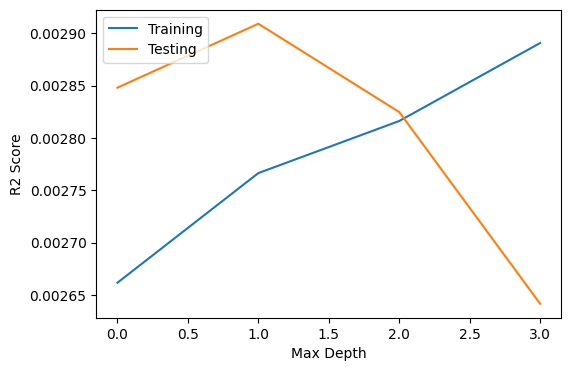

In [888]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Regressor 

In [889]:
df = pd.read_csv('weather_data_excel.csv')

In [890]:
df['Date'] = pd.to_datetime(df['Date'])

In [891]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

In [892]:
location_encoder = LabelEncoder()
df['Location_encoded'] = location_encoder.fit_transform(df['Location'])

In [893]:
# Establish X and y
y = df['Precipitation_mm']
X = df.drop(columns=['Precipitation_mm','Military_Time','Rain_Category', 'Location', 'Date', 'Precipitation_in', 'Temperature_C', 'Rain_Cat_Num', 'Date_Time'])

In [894]:
# Check if the correct columns for X have been added
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Year', 'Location_encoded'],
      dtype='object')

In [895]:
# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4700)

In [896]:
# Create XGBoost Regression Model

xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = 10 )

In [897]:
# Fit the model
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [898]:
# Determine Training R2 Score
prediction = xgb_r.predict(X_train)
training_r2 = r2_score(y_train, prediction )
training_r2

0.031871178280234336

In [899]:
# Determine Testing R2 Score
prediction = xgb_r.predict(X_test)
testing_r2 = r2_score(y_test, prediction )
testing_r2

0.028456828603069195

### Test XGBoost Regressor at depths 1 through 10

In [900]:
training_r2 = []
testing_r2 = []

In [901]:
for trees in range(1, 30):
    xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = trees)
    xgb_r.fit(X_train, y_train)
    
    y_train_pred = xgb_r.predict(X_train)
    training_r2.append(r2_score(y_train, y_train_pred))
    
    y_test_pred = xgb_r.predict(X_test)
    testing_r2.append(r2_score(y_test, y_test_pred))
    

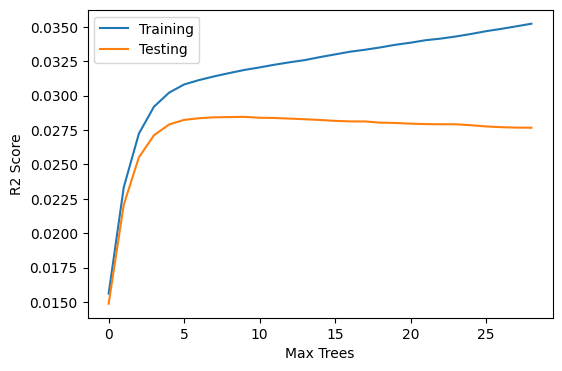

In [902]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Trees')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Classifier: Percentage Rainfall


In [903]:
data_frame = pd.read_csv('weather_data_excel.csv')

In [904]:
data_frame['Date'] = pd.to_datetime(data_frame['Date'])

In [905]:
data_frame['Month'] = data_frame['Date'].dt.month
data_frame['Day'] = data_frame['Date'].dt.day


In [906]:
location_encoder = LabelEncoder()

In [907]:
data_frame['Location_encoded'] = location_encoder.fit_transform(data_frame['Location'])

In [908]:
# This is the threshold, in mm, for if rainfall is classified as rain or not
# 0.254mm is the threshold the National Weather Service uses when determine if precipitation should be reported as rain
threshold = 0.254
data_frame['Rainfall'] = (data_frame['Precipitation_mm'] >= threshold).astype(int)

In [909]:
data_frame_pos = data_frame[data_frame['Rainfall']==1]
data_frame_neg = data_frame[data_frame['Rainfall']==0]

num = data_frame.shape[0]
num_pos = data_frame_pos.shape[0]
num_neg = data_frame_neg.shape[0]

print('Number of examples = ', num)
print('Number of positive examples = ', num_pos)
print('Number of negative examples = ', num_neg)
print(f'Percentage of positive examples = {np.round((num_pos / num) * 100, 4)}%')


Number of examples =  1000000
Number of positive examples =  975735
Number of negative examples =  24265
Percentage of positive examples = 97.5735%


In [910]:
data_frame.sample(5)

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in,Month,Day,Location_encoded,Rainfall
155645,Chicago,1/29/2024 17:52,6.512245,51.854774,1.612469,23.232564,43.722042,2024-01-29,17:52,Light Rain,0,0.063483,1,29,0,1
915446,Chicago,2/15/2024 22:33,7.642419,83.598451,9.265416,8.579704,45.756355,2024-02-15,22:33,Heavy Rain,2,0.364780,2,15,0,1
69183,New York,1/23/2024 22:06,15.265828,41.629440,0.720999,28.508546,59.478490,2024-01-23,22:06,Light Rain,0,0.028386,1,23,4,1
349620,New York,3/20/2024 17:26,37.433414,34.797383,3.596574,10.047486,99.380145,2024-03-20,17:26,Moderate Rain,1,0.141597,3,20,4,1
208506,Chicago,5/1/2024 6:36,23.173138,57.887246,2.155895,1.305344,73.711648,2024-05-01,06:36,Light Rain,0,0.084878,5,1,0,1


In [911]:
y=data_frame['Rainfall']

In [912]:
X = data_frame.drop(columns=['Precipitation_in', 'Precipitation_mm', 'Date', 'Military_Time', 'Rain_Category', 'Rain_Cat_Num', 'Location', 'Rainfall', 'Date_Time', 'Temperature_C'])

In [913]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Location_encoded'],
      dtype='object')

In [914]:
X.sample(5)

,Humidity_pct,Wind_Speed_kmh,Temperature_F,Month,Day,Location_encoded
695857,58.916294,26.957787,16.100656,2,16,9
899213,77.872790,21.546294,33.814633,4,3,9
418764,43.286724,17.830704,41.134928,5,13,5
743876,77.387364,22.026984,61.009421,4,3,2
560136,68.612113,27.180729,99.384229,3,1,1


In [915]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4700)

In [916]:
xgb_c = xgboost.XGBClassifier( n_estimators = 100, max_depth = 10 )

In [917]:
xgb_c.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [918]:
y_train_pred = xgb_c.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
training_accuracy

0.976185

In [919]:
y_test_pred = xgb_c.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_test_pred)
testing_accuracy


0.975895

In [920]:
# Saving the model and encoder
#dump(xgb_c, 'rain_probability_predictor.pkl')
#dump(location_encoder, 'location_encoder.pkl')

### See how important each input is 

In [921]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Location_encoded'],
      dtype='object')

In [922]:
xgb_c.feature_importances_

array([0.16067868, 0.1614316 , 0.1611361 , 0.17257822, 0.15485017,
       0.18932527], dtype=float32)

### Visualise Data

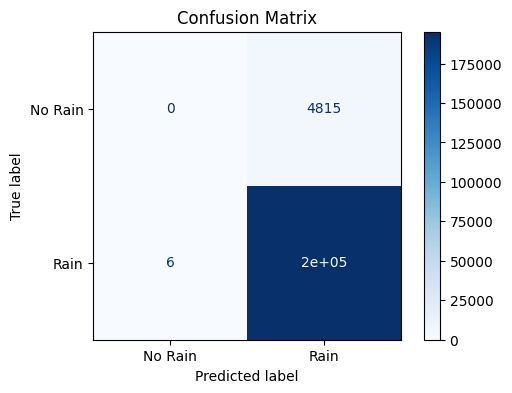

In [923]:
y_pred = xgb_c.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## XGBoost Classifier

In [924]:
# Write XGB Classifier Code Here
# edf = pd.read_excel('weather_data_excel.xlsx')
edf = pd.read_csv('weather_data_excel.csv')
edf = edf.iloc[:1000000]
edf

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in
0,San Jose,4/16/2024 3:44,17.199707,71.429300,0.000009,4.665638,62.959473,4/16/2024,03:44,Light Rain,0,3.505573e-07
1,Houston,3/21/2024 15:32,2.238515,51.415780,0.000010,3.578842,36.029327,3/21/2024,15:32,Light Rain,0,4.092205e-07
2,Houston,2/27/2024 1:05,29.209095,50.340174,0.000029,9.968438,84.576371,2/27/2024,01:05,Light Rain,0,1.157432e-06
3,Phoenix,4/23/2024 0:39,15.041607,78.159361,0.000032,21.713389,59.074893,4/23/2024,00:39,Light Rain,0,1.261625e-06
4,San Diego,5/2/2024 20:45,12.799834,62.244326,0.000089,27.277552,55.039702,5/2/2024,20:45,Light Rain,0,3.493707e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,Phoenix,2/22/2024 8:35,-0.872399,37.180646,14.896195,18.147337,30.429682,2/22/2024,08:35,Heavy Rain,2,5.864644e-01
999996,Phoenix,1/10/2024 19:03,14.200155,78.319692,14.912323,19.157155,57.560279,1/10/2024,19:03,Heavy Rain,2,5.870993e-01
999997,Phoenix,1/8/2024 21:01,19.848658,75.733769,14.917006,15.453639,67.727585,1/8/2024,21:01,Heavy Rain,2,5.872837e-01
999998,Phoenix,1/16/2024 8:12,-3.586550,81.166402,14.926332,13.758749,25.544210,1/16/2024,08:12,Heavy Rain,2,5.876509e-01


In [925]:
edf['Hour'] = edf['Military_Time'].apply(lambda x: int(x.split(":")[0]))
edf['Minute'] = edf['Military_Time'].apply(lambda x: int(x.split(":")[1]))
edf

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in,Hour,Minute
0,San Jose,4/16/2024 3:44,17.199707,71.429300,0.000009,4.665638,62.959473,4/16/2024,03:44,Light Rain,0,3.505573e-07,3,44
1,Houston,3/21/2024 15:32,2.238515,51.415780,0.000010,3.578842,36.029327,3/21/2024,15:32,Light Rain,0,4.092205e-07,15,32
2,Houston,2/27/2024 1:05,29.209095,50.340174,0.000029,9.968438,84.576371,2/27/2024,01:05,Light Rain,0,1.157432e-06,1,5
3,Phoenix,4/23/2024 0:39,15.041607,78.159361,0.000032,21.713389,59.074893,4/23/2024,00:39,Light Rain,0,1.261625e-06,0,39
4,San Diego,5/2/2024 20:45,12.799834,62.244326,0.000089,27.277552,55.039702,5/2/2024,20:45,Light Rain,0,3.493707e-06,20,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,Phoenix,2/22/2024 8:35,-0.872399,37.180646,14.896195,18.147337,30.429682,2/22/2024,08:35,Heavy Rain,2,5.864644e-01,8,35
999996,Phoenix,1/10/2024 19:03,14.200155,78.319692,14.912323,19.157155,57.560279,1/10/2024,19:03,Heavy Rain,2,5.870993e-01,19,3
999997,Phoenix,1/8/2024 21:01,19.848658,75.733769,14.917006,15.453639,67.727585,1/8/2024,21:01,Heavy Rain,2,5.872837e-01,21,1
999998,Phoenix,1/16/2024 8:12,-3.586550,81.166402,14.926332,13.758749,25.544210,1/16/2024,08:12,Heavy Rain,2,5.876509e-01,8,12


In [926]:
#Removing empety rows
X = edf.drop(columns=["Date", "Location", "Rain_Cat_Num", "Rain_Category", 'Military_Time', 'Precipitation_mm', 'Date_Time'])
X

,Temperature_C,Humidity_pct,Wind_Speed_kmh,Temperature_F,Precipitation_in,Hour,Minute
0,17.199707,71.429300,4.665638,62.959473,3.505573e-07,3,44
1,2.238515,51.415780,3.578842,36.029327,4.092205e-07,15,32
2,29.209095,50.340174,9.968438,84.576371,1.157432e-06,1,5
3,15.041607,78.159361,21.713389,59.074893,1.261625e-06,0,39
4,12.799834,62.244326,27.277552,55.039702,3.493707e-06,20,45
...,...,...,...,...,...,...,...
999995,-0.872399,37.180646,18.147337,30.429682,5.864644e-01,8,35
999996,14.200155,78.319692,19.157155,57.560279,5.870993e-01,19,3
999997,19.848658,75.733769,15.453639,67.727585,5.872837e-01,21,1
999998,-3.586550,81.166402,13.758749,25.544210,5.876509e-01,8,12


In [927]:
y = edf["Rain_Cat_Num"]
y

0         0
1         0
2         0
3         0
4         0
         ..
999995    2
999996    2
999997    2
999998    2
999999    2
Name: Rain_Cat_Num, Length: 1000000, dtype: int64

In [928]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [929]:
y_train

408951    1
247757    1
83790     0
485697    1
129449    0
         ..
713981    1
74853     0
808531    2
884828    2
739025    1
Name: Rain_Cat_Num, Length: 700000, dtype: int64

In [930]:
y_test

279100    1
515719    1
864943    2
79016     0
926839    2
         ..
123785    0
823250    2
728262    1
472925    1
274764    1
Name: Rain_Cat_Num, Length: 300000, dtype: int64

In [931]:
from xgboost import XGBClassifier

In [932]:
xgb_clf = XGBClassifier(n_estimators=25, max_depth=5)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [933]:
from sklearn.metrics import accuracy_score

In [934]:
y_train_pred = xgb_clf.predict(X_train)

In [935]:
accuracy_score(y_train, y_train_pred)

0.9989528571428572

In [936]:
y_test_pred = xgb_clf.predict(X_test)

In [937]:
accuracy_score(y_test, y_test_pred)

0.9988933333333333

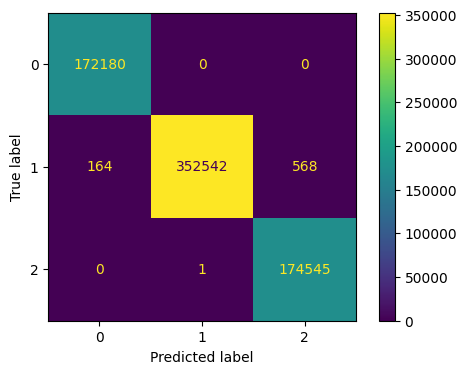

In [938]:
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [939]:
# r2Train = []
# r2Test = []
# for i in range(1, 31):
#     xgb = XGBClassifier(n_estimators=25, max_depth=1)
#     xgb.fit(X_train, y_train)
#     y_train_pred = dt.predict(X_train)
#     r2Train.append(r2_score(y_train, y_train_pred))
#     y_test_pred = dt.predict(X_test)
#     r2Test.append(r2_score(y_test, y_test_pred))

## Tensor Flow Neuro Network

In [940]:
# Write Tensor Flow Neuro Network Code Here

In [941]:
print("hello")

hello
